In [126]:
from tika import parser
import re
import timeit
import os
import pandas as pd
import string

In [144]:
def generate_raw_data():
    
    """
    This function generates raw text data from FOMC transcripts
    
    returns a list where each element is the full text within each FOMC meeting
    
    It will take about 4-5 minutes
    """

    cwd = os.getcwd() # get current working directory
    base_directory = './FOMC_pdf' # set directory of pdfs
    raw_doc = os.listdir(base_directory) # as above
    filelist = sorted(raw_doc) # sort the pdfs in order
    onlyfiles = [f for f in raw_doc if os.path.isfile(os.path.join(base_directory, f))] # keep if in correct dir
    date = [f[4:10] for f in onlyfiles] # keep the dates in pdfs

    raw_text = pd.DataFrame(columns = ['Date','Speaker', 'content']) #empty dataframe

    start = timeit.default_timer()
    for i,file in enumerate(filelist):
        print('Document {} of {}'.format(i, len(filelist)))
        
        parsed = parser.from_file(os.path.join(cwd, 'FOMC_pdf',file)) # parse the pdf
        interjections = re.split('\nMR. |\nMS. |\nCHAIRMAN |\nVICE CHAIRMAN ', parsed['content']) # split the entire string by the names (looking for MR, MS, Chairman or Vice Chairman)
        temp_df = pd.DataFrame(columns = ['Date','Speaker','content']) # create a temporary dataframe
        interjections = [interjection.replace('\n',' ') for interjection in interjections] # replace \n linebreaks with spaces
        temp = [re.split('(^\S*)', interjection.lstrip()) for interjection in interjections] # changed to this split because sometimes (rarely) there was not a period, either other punctuation or whitespace
        
        speaker = []
        content = []
        for interjection in temp:
            speaker.append(interjection[1].strip(string.punctuation))
            content.append(interjection[2])
            
        temp_df['Speaker'] = speaker

        temp_df['content'] = content # save interjections

        temp_df['Date'] = date[i]
        raw_text = pd.concat([raw_text, temp_df], ignore_index = True)

    end = timeit.default_timer()
    raw_text.index = raw_text['Date'] # set dataframe index to the Date
    raw_text.to_excel('raw_text.xlsx') # save as raw_text.xlsx

    print("Documents processed. Time: {}".format(end - start))
    
    return raw_text


In [292]:
import pandas as pd
import topicmodels
import numpy as np
from nltk.stem import PorterStemmer
import nltk
from nltk.collocations import *

def preprocess():
    
    
    '''
    main function for preprocessing
        
    This function writes the tokenized documents, which includes columns of 
    
    Date: date of the meeting
    Section: FOMC1 or FOMC2
    Speaker: speaker of the interjection
    content: list of tokens in the interjection
    
    '''
    
    
    text = pd.read_excel('raw_text.xlsx')
    
    text_separated = separation(text)
    
    text_separated_col = find_collocation(text_separated)
    text_separated_col['content'] = tokenize(text_separated_col['content'].values)
    text_separated_col.to_excel('FOMC_token_separated_col.xlsx')
    
def tokenize(content):
    '''
    Code for tokenization:
        1. remove words with length of 1
        2. remove non-alphabetical words
        3. remove stop words
        4. stem all words
    '''
    FOMC_token = []
    for statement in content:
        statement = statement.lower()
        docsobj = topicmodels.RawDocs([statement], "long")
        docsobj.token_clean(1)
        docsobj.stopword_remove("tokens")
        docsobj.stem()
        docsobj.stopword_remove("stems")
        ps = PorterStemmer()
        FOMC_token.append(' '.join([ps.stem(word) for word in docsobj.tokens[0]]))
        
    return FOMC_token

def separation(raw_text):
    
    separation_rule = pd.read_excel('Separation.xlsx')
    
    FOMC_separation = pd.DataFrame(columns = ['Date','Speaker','content','Section'])
    for i in separation_rule.index:

        temp1 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC1_start'][i]:separation_rule['FOMC1_end'][i]]
        temp1['Section'] = 1
        if separation_rule['FOMC2_end'][i] == 'end':
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:]
        else:
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:separation_rule['FOMC2_end'][i]]
        temp2['Section'] = 2
        FOMC_separation = FOMC_separation.append(temp1, ignore_index=True)
        FOMC_separation = FOMC_separation.append(temp2, ignore_index = True)
        
    FOMC_separation.to_excel('raw_text_separated.xlsx')
    return FOMC_separation

def find_collocation(raw_text_separated):
    
    content = raw_text_separated['content'].apply(lambda x: re.sub(r'[^\w\s]','',x)) #remove punctuations
    
    big_document = content.apply(lambda x: x.split(' ')).values
    
    bigram_list = bigrams(big_document)
    trigram_list = trigram(big_document)
    
    replace_word = [''.join(x.split(' ')) + 'xx' for x in bigram_list] + [''.join(x.split(' ')) + 'xxx' for x in trigram_list]
    
    dict_collocation = dict(zip(bigram_list + trigram_list, replace_word))

    content = content.apply(lambda x: replace_collocation(x, dict_collocation))
    
    raw_text_separated['content'] = content
    raw_text_separated.to_excel('FOMC_separated_Collocation.xlsx')
    return raw_text_separated

def bigrams(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    bigram_measures = nltk.collocations.BigramAssocMeasures()

    finder = BigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(150)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]


def trigram(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    trigram_measures = nltk.collocations.TrigramAssocMeasures()

    finder = TrigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(100)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]

def replace_collocation(string, dict_collocation):
    
    for key in dict_collocation.keys():
        
        string = string.replace(key, dict_collocation[key])
        
    return string

In [315]:
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt

def generate_term_document():
    
    data = pd.read_excel('FOMC_token_separated_col.xlsx')
    texts = []
    for line in data['content'].fillna(' ').values:
        texts.append(line.split(' '))
        
    dictionary2 = corpora.Dictionary(texts)
    corpus2 = [dictionary2.doc2bow(text) for text in texts]
    
    term_document2 = gensim.matutils.corpus2dense(corpus2, num_terms=len(dictionary2.keys()))
    
    TF = 1+np.log(term_document2.sum(axis = 1))
    IDF = np.log(term_document2.shape[1] / np.count_nonzero(term_document2, axis = 1))

    TF_IDF = pd.Series(dict(zip(dictionary2.keys(), TF*IDF)))
    
    # use top 9000 in TF-IDF
    keys_to_use2 = TF_IDF.sort_values(ascending = False)[:9000].index.values
    
    TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
    plt.show()
    
    dictionary2.filter_tokens(good_ids = keys_to_use2)
    new_corpus2 = [dictionary2.doc2bow(text) for text in texts]
    
    new_term_document2 = gensim.matutils.corpus2dense(new_corpus2, num_terms=len(dictionary2.keys()))
    
    pd.DataFrame(new_term_document2).to_csv('Matrix_interjection_tfidf.csv')
    
    return new_term_document2

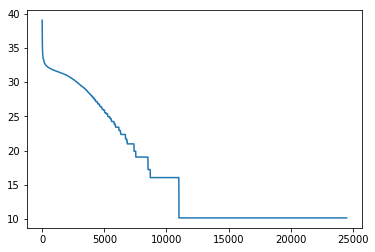

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [316]:
generate_term_document()